# Read and analyze MCMC chain (from Eryn)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import h5py

from emcee.autocorr import integrated_time

from matplotlib.ticker import ScalarFormatter

Load the file

In [2]:
filename = ["1_sect4.h5", "2_sect4.h5", "3_sect4.h5", "4_sect4.h5"]

In [3]:
chains = {}

for i in range(len(filename)):
    f = h5py.File(filename[i], 'r')

    emri_chain_complete = f['mcmc/chain/emri'][:]
    emri_chain = emri_chain_complete[:np.count_nonzero(emri_chain_complete[:, 0, 0, 0, 0]), :, :, :, :]    
    #emri_chain = emri_chain_complete[:, :, :, :, :]
    f.close()

    nsteps, ntemps, nwalkers, nbranches, ndims = emri_chain.shape

    tau = integrated_time(emri_chain[:, 0, :, 0, :], quiet=True)
    print(filename[i])
    print('Autocorrelation time: '+str(tau))

    thin = int(np.ceil(np.max(tau)))

    burnin = 4*thin
    samples = emri_chain[burnin:, 0, :, 0, :]  # [steps after burnin, temp=0, all walkers, branch dim=0, parameters]

    print('Original nsteps: '+str(emri_chain.shape[0]))
    print('Burned-in  nsteps: '+str(samples.shape[0]))

    thin_samples = samples[::thin, :, :]

    print("Burned-in  nsteps:", samples.shape[0])
    print("Burned-in and thinned  nsteps:", thin_samples.shape[0])

    flat_samples = thin_samples.reshape(-1, ndims)  # Combine steps and walkers dimensions
    print(f"Flattened samples shape: {flat_samples.shape}")

    chain_name = f"chain_{i}"
    chains[chain_name] = flat_samples

    print()
    print()

#print(chains["chain_0"].shape)  # accede a chain_0
#print(chains["chain_1"].shape)  # accede a chain_1

1_sect4.h5
Autocorrelation time: [8.96771291 7.22781352 9.36058635 9.36194533 7.51666045 8.20711012
 7.72913062 7.88414778 8.84288766 8.17975341 8.41799471 7.71007533
 8.21005046]
Original nsteps: 1000
Burned-in  nsteps: 960
Burned-in  nsteps: 960
Burned-in and thinned  nsteps: 96
Flattened samples shape: (3072, 13)


2_sect4.h5
Autocorrelation time: [9.20651243 8.35708352 9.26260761 9.26843693 8.75398653 7.52500819
 6.47601137 6.8102412  7.38776159 8.05963546 6.50016788 5.2235341
 7.4850594 ]
Original nsteps: 1000
Burned-in  nsteps: 960
Burned-in  nsteps: 960
Burned-in and thinned  nsteps: 96
Flattened samples shape: (3072, 13)


3_sect4.h5
Autocorrelation time: [8.38690473 7.99488993 8.38401578 8.39673076 8.23135543 8.32703317
 8.03743565 9.19797604 8.46336491 9.01682593 8.78905906 7.66650834
 7.67204604]
Original nsteps: 1000
Burned-in  nsteps: 960
Burned-in  nsteps: 960
Burned-in and thinned  nsteps: 96
Flattened samples shape: (3072, 13)


4_sect4.h5
Autocorrelation time: [7.20398

Posteriors

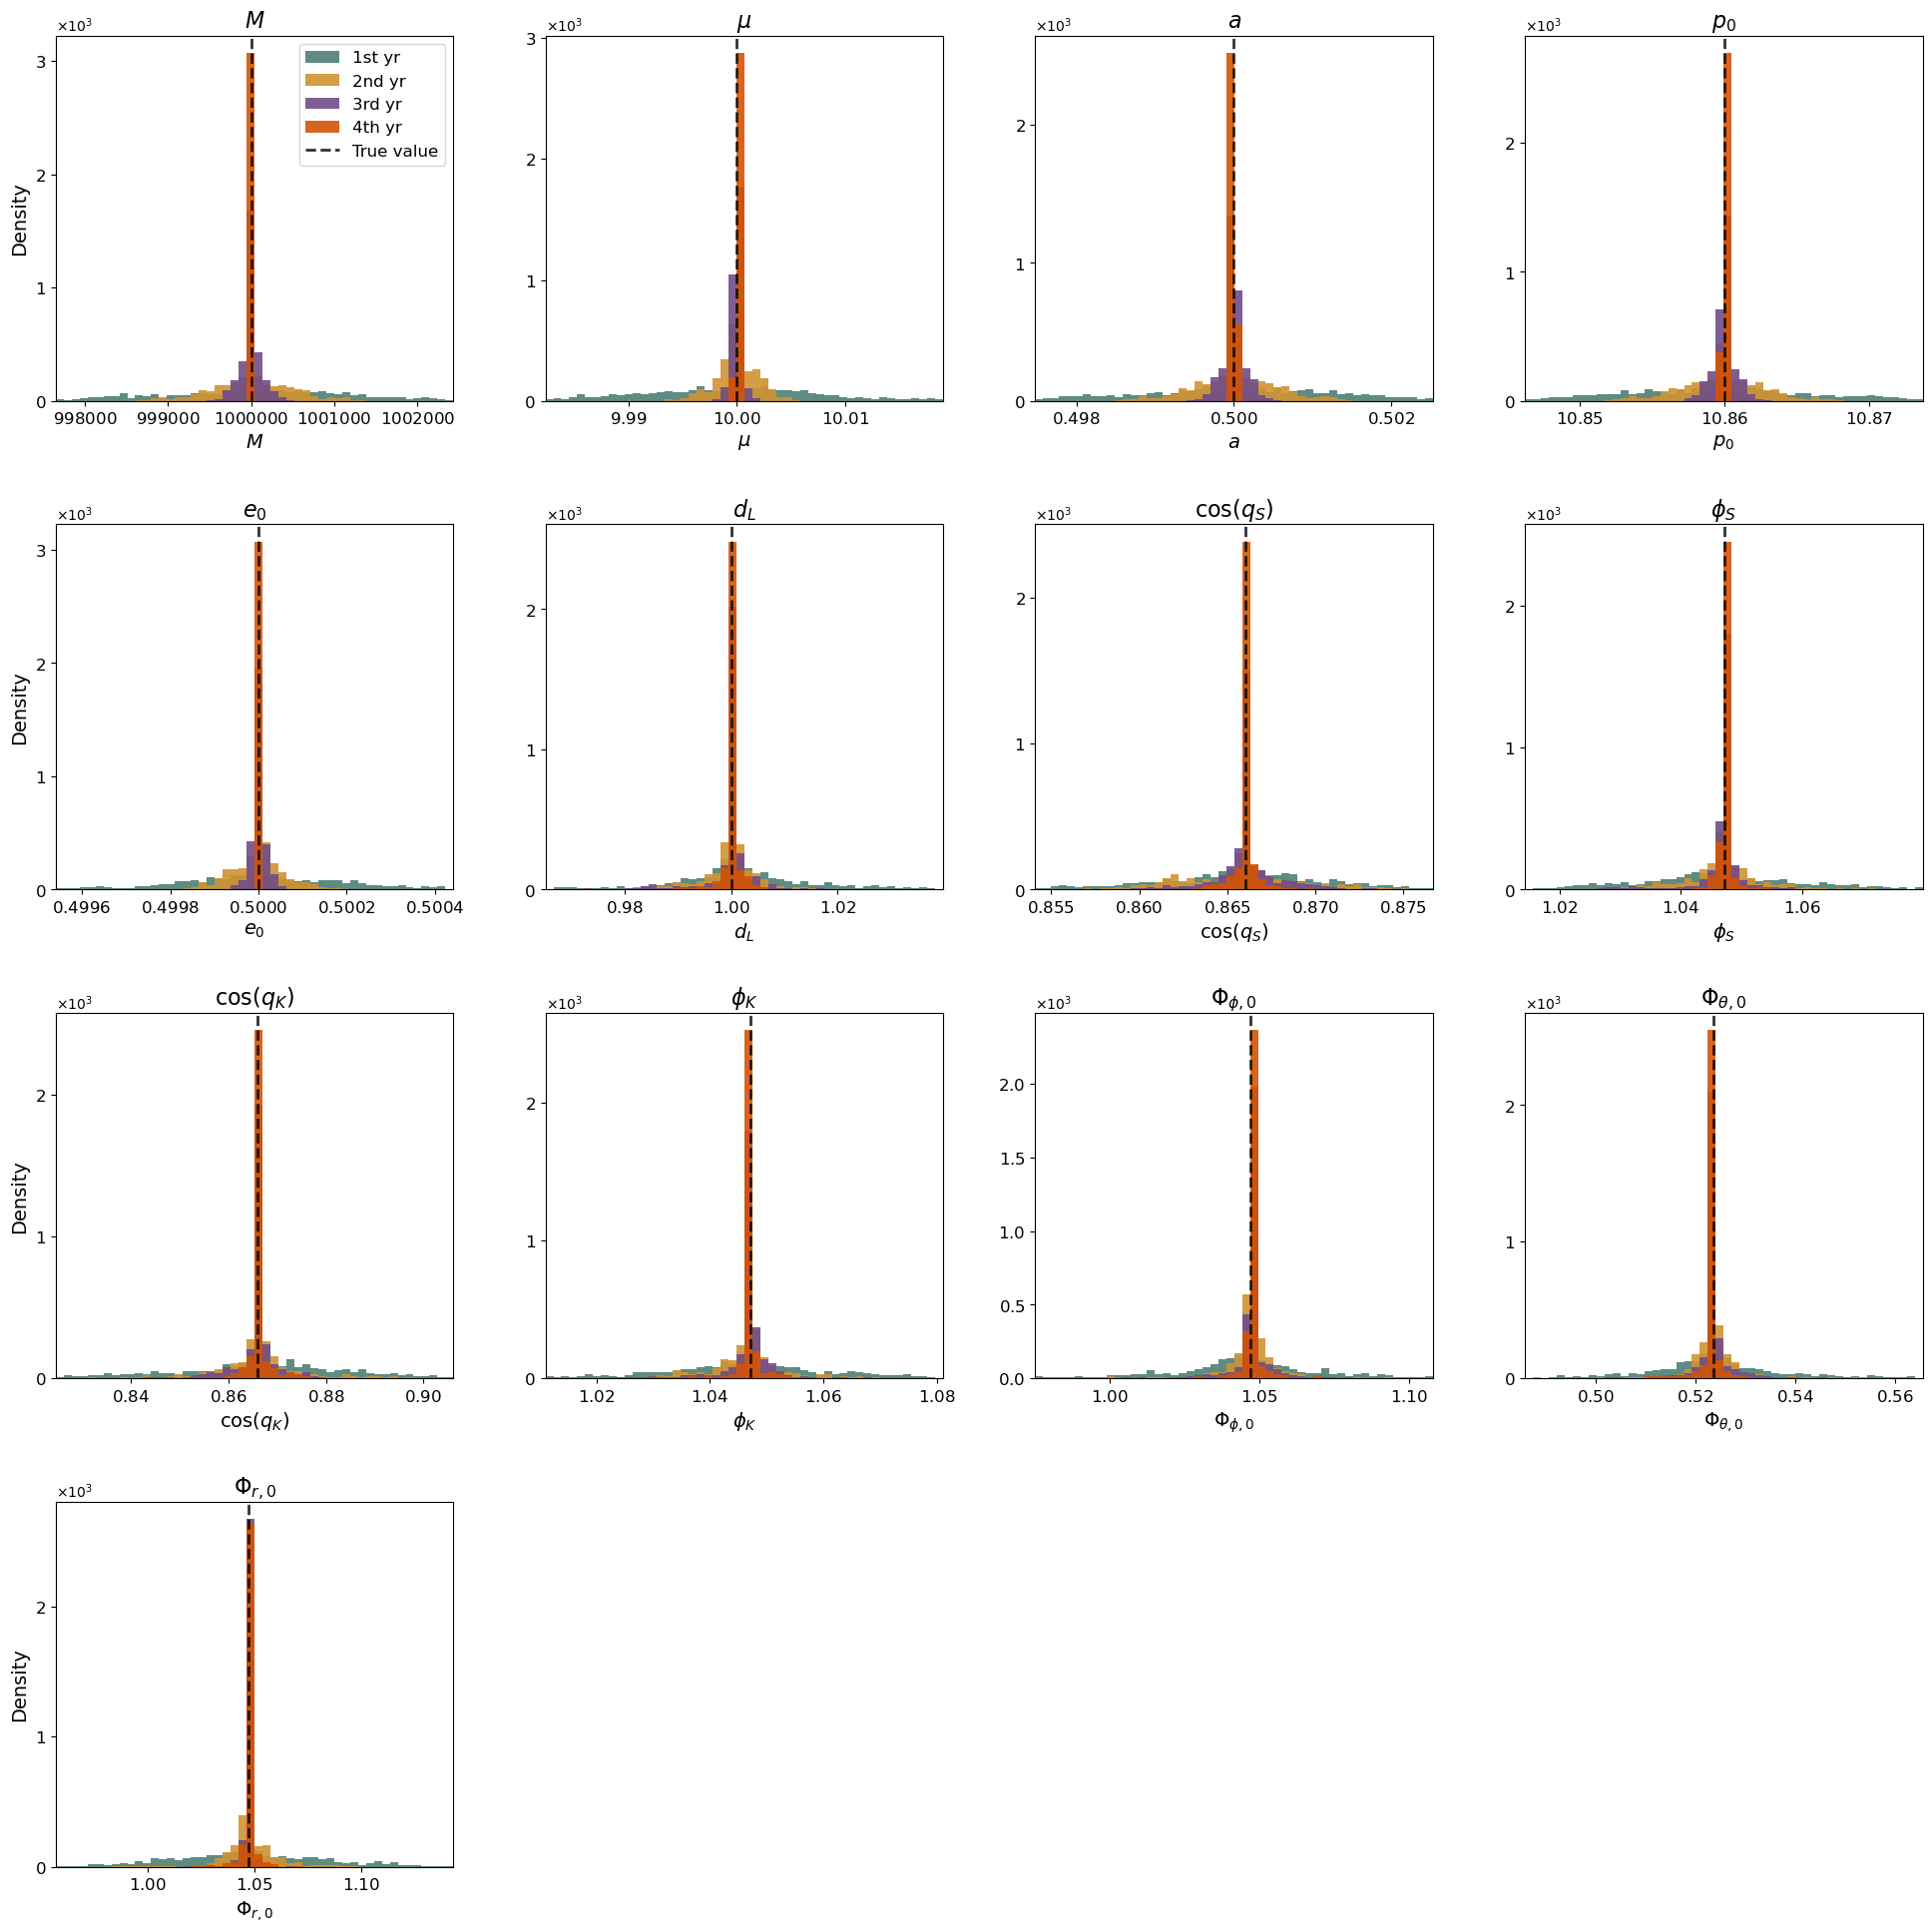

In [16]:
ndims = 13

label_chains = ['1st yr', '2nd yr', '3rd yr', '4th yr']

labels = [r'$M$', r'$\mu$', r'$a$', r'$p_0$', r'$e_0$', r'$d_L$', 
          r'$\cos(q_S)$', r'$\phi_S$', r'$\cos(q_K)$', r'$\phi_K$', 
          r'$\Phi_{\phi,0}$', r'$\Phi_{\theta,0}$', r'$\Phi_{r,0}$']

true_param = [1e6, 10, 0.5, 10.86, 0.5, 1.0, np.cos(np.pi / 6), np.pi / 3, 
              np.cos(np.pi / 6), np.pi / 3, np.pi / 3, np.pi / 6, np.pi / 3]

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

#colors = ['#663399', '#FF8C42', '#2E8B57', '#4682B4', '#DC143C']  
colors = ['#4C8076', '#d19331', '#704C88', '#d45404']  

# Cleaner tick labels (scientific notation with max 2 significant figures)
def format_ticks(ax):
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    formatter.set_scientific(True)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.locator_params(axis='both', nbins=5)  # Limit number of ticks for cleaner appearance


for param_idx in range(ndims):
    ax = axes[param_idx]

    
    # Calculate percentiles for zoom (removes extreme outliers)
    all_values = []
    for chain_name, chain_data in chains.items():
        all_values.extend(chain_data[:, param_idx])

    p1, p99 = np.percentile(all_values, [1, 99])
    margin = (p99 - p1) * 0.1  # 10% margin


    # Create histogram with optimized range
    for i, (chain_name, chain_data) in enumerate(chains.items()):
        param_values = chain_data[:, param_idx]
        
        ax.hist(param_values, bins=50, alpha=0.9, 
                label=f'{label_chains[i]}', 
                color=colors[i % len(colors)],
                density=False,
                range=(p1 - margin, p99 + margin))
    
    ax.axvline(true_param[param_idx], color='black', linestyle='--', 
               linewidth=2, alpha=0.8, label='True value')  # Vertical line for true value

    
    # Appearance
    ax.set_title(f'{labels[param_idx]}', fontsize=16, fontweight='bold')
    ax.set_xlabel(f'{labels[param_idx]}', fontsize=14)

    if param_idx % 4 == 0:
        ax.set_ylabel('Density', fontsize=14)       # y axis title only for first column
    
    if param_idx == 0:
        ax.legend(fontsize=12, loc='upper right')   # Legend only in first subplot
    
    format_ticks(ax)   # Apply custom tick formatting
    
    ax.tick_params(labelsize=12)
    ax.set_xlim(p1 - margin, p99 + margin)


# Remove all empty subplots
for i in range(ndims, 16):
    fig.delaxes(axes[i])

plt.tight_layout(pad=3.0)  # More space between subplots
plt.savefig("sect_distrib_plot.pdf", dpi=600, bbox_inches="tight")
plt.show()

### Compare half widths

['chain_0', 'chain_1', 'chain_2', 'chain_3']


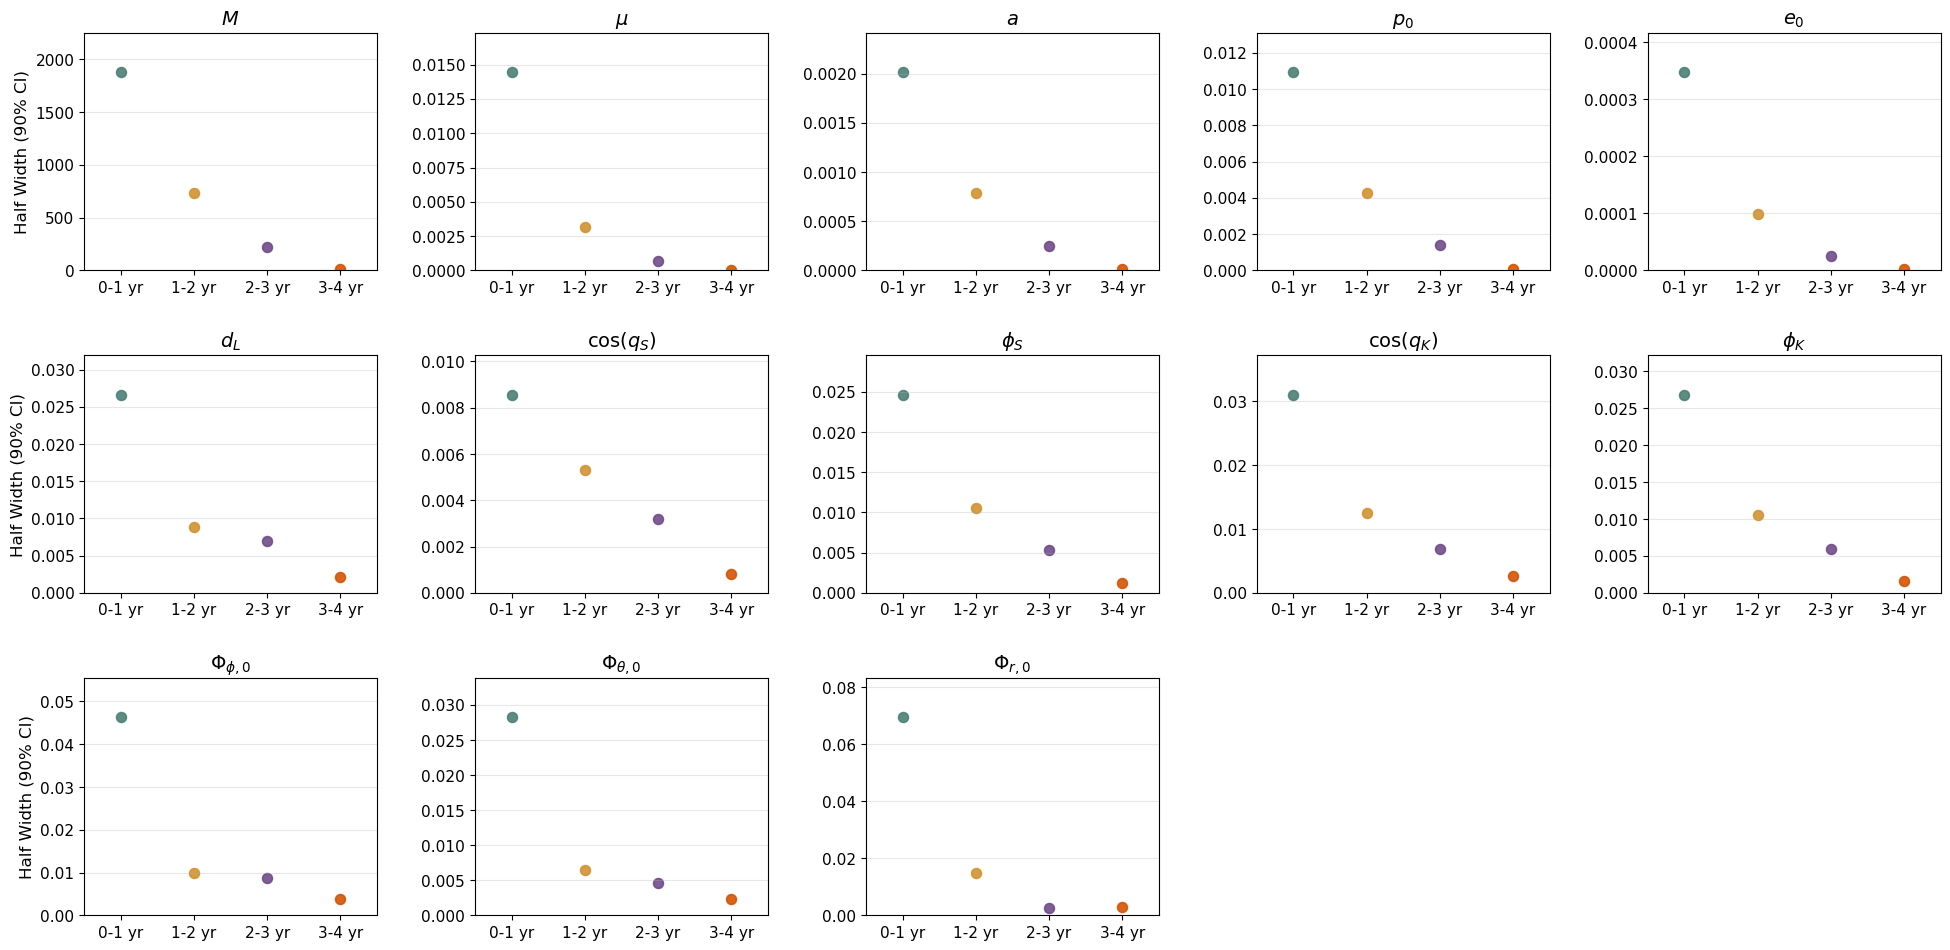

In [10]:
ndims = 13

labels = [r'$M$', r'$\mu$', r'$a$', r'$p_0$', r'$e_0$', r'$d_L$', 
          r'$\cos(q_S)$', r'$\phi_S$', r'$\cos(q_K)$', r'$\phi_K$', 
          r'$\Phi_{\phi,0}$', r'$\Phi_{\theta,0}$', r'$\Phi_{r,0}$']


chain_keys   = list(chains.keys())         # ['chain_0', 'chain_1', 'chain_2', 'chain_3']
print(chain_keys)
label_chains = ['0-1 yr', '1-2 yr', '2-3 yr', '3-4 yr']   # stesse posizioni

#colors = ['#663399', '#FF8C42', '#2E8B57', '#4682B4', '#DC143C']  
colors = ['#4C8076', '#d19331', '#704C88', '#d45404']  



half_widths = {k: [] for k in chain_keys}
for k in chain_keys:
    samples = chains[k]
    for j in range(ndims):
        p5, p95 = np.percentile(samples[:, j], [5, 95])
        half_widths[k].append((p95 - p5) / 2)
        #print(half_widths)



fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

for idx in range(ndims):
    ax = axes[idx]
    for i, key in enumerate(chain_keys):
        hw = half_widths[key][idx]
        ax.scatter(
            i, hw,
            color=colors[i],
            marker='o',
            s=50,
            #edgecolors='black',
            linewidth=1.2,
            alpha=0.9
        )
    ax.set_title(labels[idx], fontsize=14)
    if idx % 5 == 0:
        ax.set_ylabel('Half Width (90% CI)', fontsize=12)
    ax.set_xticks([0, 1,2,3])
    ax.set_xticklabels(label_chains, fontsize=11)
    ax.set_xlim(-0.5, len(chain_keys)-0.5)  # ora copre tutte le catene
    yvals = [half_widths[k][idx] for k in chain_keys]
    ax.set_ylim(0, max(yvals) * 1.2)
    ax.grid(True, axis='y', alpha=0.3)
    ax.tick_params(labelsize=11)


for k in range(ndims, 15):
    fig.delaxes(axes[k])

fig.tight_layout(pad=2.5)
plt.savefig("sect_halfwidth_plot.pdf", dpi=600, bbox_inches="tight")
plt.show()

Half Width ratio

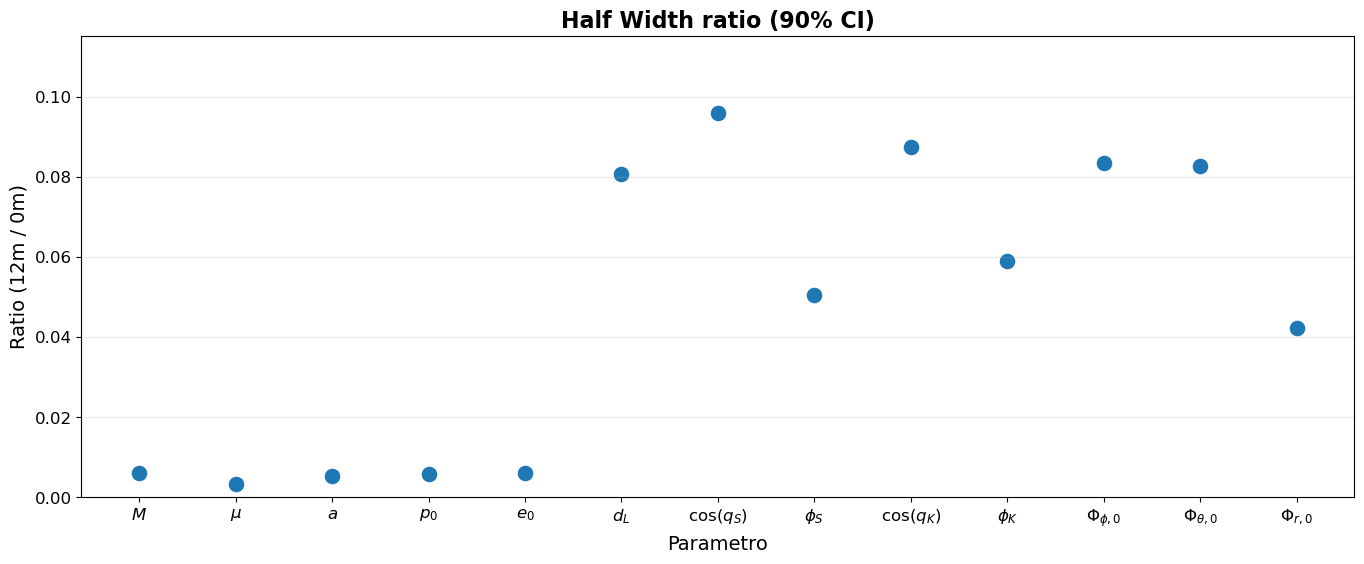

Half Width ratio (3-4yr / 0-1yr):
$M$         : 0.006
$\mu$       : 0.003
$a$         : 0.005
$p_0$       : 0.006
$e_0$       : 0.006
$d_L$       : 0.081
$\cos(q_S)$ : 0.096
$\phi_S$    : 0.050
$\cos(q_K)$ : 0.087
$\phi_K$    : 0.059
$\Phi_{\phi,0}$: 0.083
$\Phi_{\theta,0}$: 0.083
$\Phi_{r,0}$: 0.042


In [6]:
fig2, ax2 = plt.subplots(figsize=(14, 6))

hw0 = np.array(half_widths[chain_keys[0]])
hw1 = np.array(half_widths[chain_keys[3]])
ratio = hw1 / hw0

x = np.arange(ndims)
ax2.scatter(
    x, ratio,
    #color=colors[1],
    #marker='o',
    s=100,
    #edgecolors='black',
    linewidth=1.2,
    #alpha=0.9
)
ax2.axhline(1.0, color='gray', linestyle='--', linewidth=1)

ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=12)
ax2.set_xlabel('Parametro', fontsize=14)
ax2.set_ylabel('Ratio (12m / 0m)', fontsize=14)
ax2.set_title('Half Width ratio (90% CI)', fontsize=16, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)
ax2.set_ylim(0, max(ratio) * 1.2)
ax2.tick_params(labelsize=12)

fig2.tight_layout(pad=2.0)
plt.show()


print("Half Width ratio (3-4yr / 0-1yr):")
for i, lab in enumerate(labels):
    print(f"{lab:12s}: {ratio[i]:.3f}")


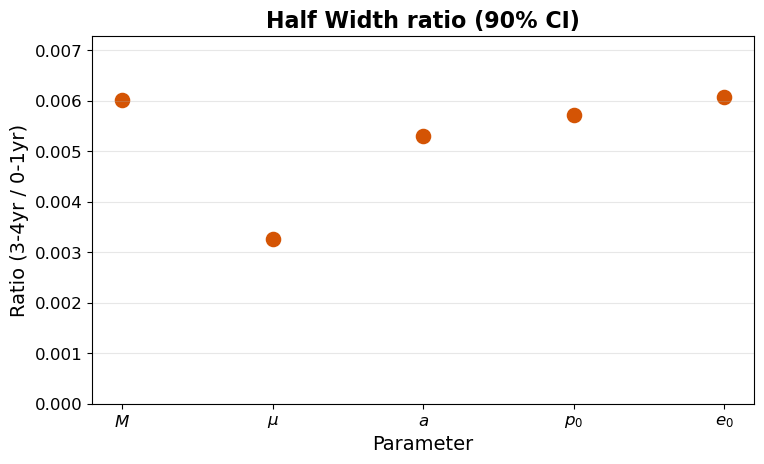

Half Width ratio (3-4yr / 0-1yr):
$M$         : 0.006
$\mu$       : 0.003
$a$         : 0.005
$p_0$       : 0.006
$e_0$       : 0.006
$d_L$       : 0.081
$\cos(q_S)$ : 0.096
$\phi_S$    : 0.050
$\cos(q_K)$ : 0.087
$\phi_K$    : 0.059
$\Phi_{\phi,0}$: 0.083
$\Phi_{\theta,0}$: 0.083
$\Phi_{r,0}$: 0.042


In [13]:
fig2, ax2 = plt.subplots(figsize=(8, 5))

hw0 = np.array(half_widths[chain_keys[0]])
hw1 = np.array(half_widths[chain_keys[3]])
ratio = hw1 / hw0

x = np.arange(5)
ax2.scatter(
    x, ratio[0:5],
    color='#d45404',
    #marker='o',
    s=100,
    #edgecolors='black',
    linewidth=1.2,
    #alpha=0.9
)
ax2.axhline(1.0, color='gray', linestyle='--', linewidth=1)

ax2.set_xticks(x)
ax2.set_xticklabels(labels[0:5], fontsize=12)
ax2.set_xlabel('Parameter', fontsize=14)
ax2.set_ylabel('Ratio (3-4yr / 0-1yr)', fontsize=14)
ax2.set_title('Half Width ratio (90% CI)', fontsize=16, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)
ax2.set_ylim(0, max(ratio[0:5]) * 1.2)
ax2.tick_params(labelsize=12)

fig2.tight_layout(pad=2.0)
plt.savefig("sect_hwRatio_plot.pdf", dpi=600, bbox_inches="tight")
plt.show()


print("Half Width ratio (3-4yr / 0-1yr):")
for i, lab in enumerate(labels):
    print(f"{lab:12s}: {ratio[i]:.3f}")

### Visualise the data of a single chain

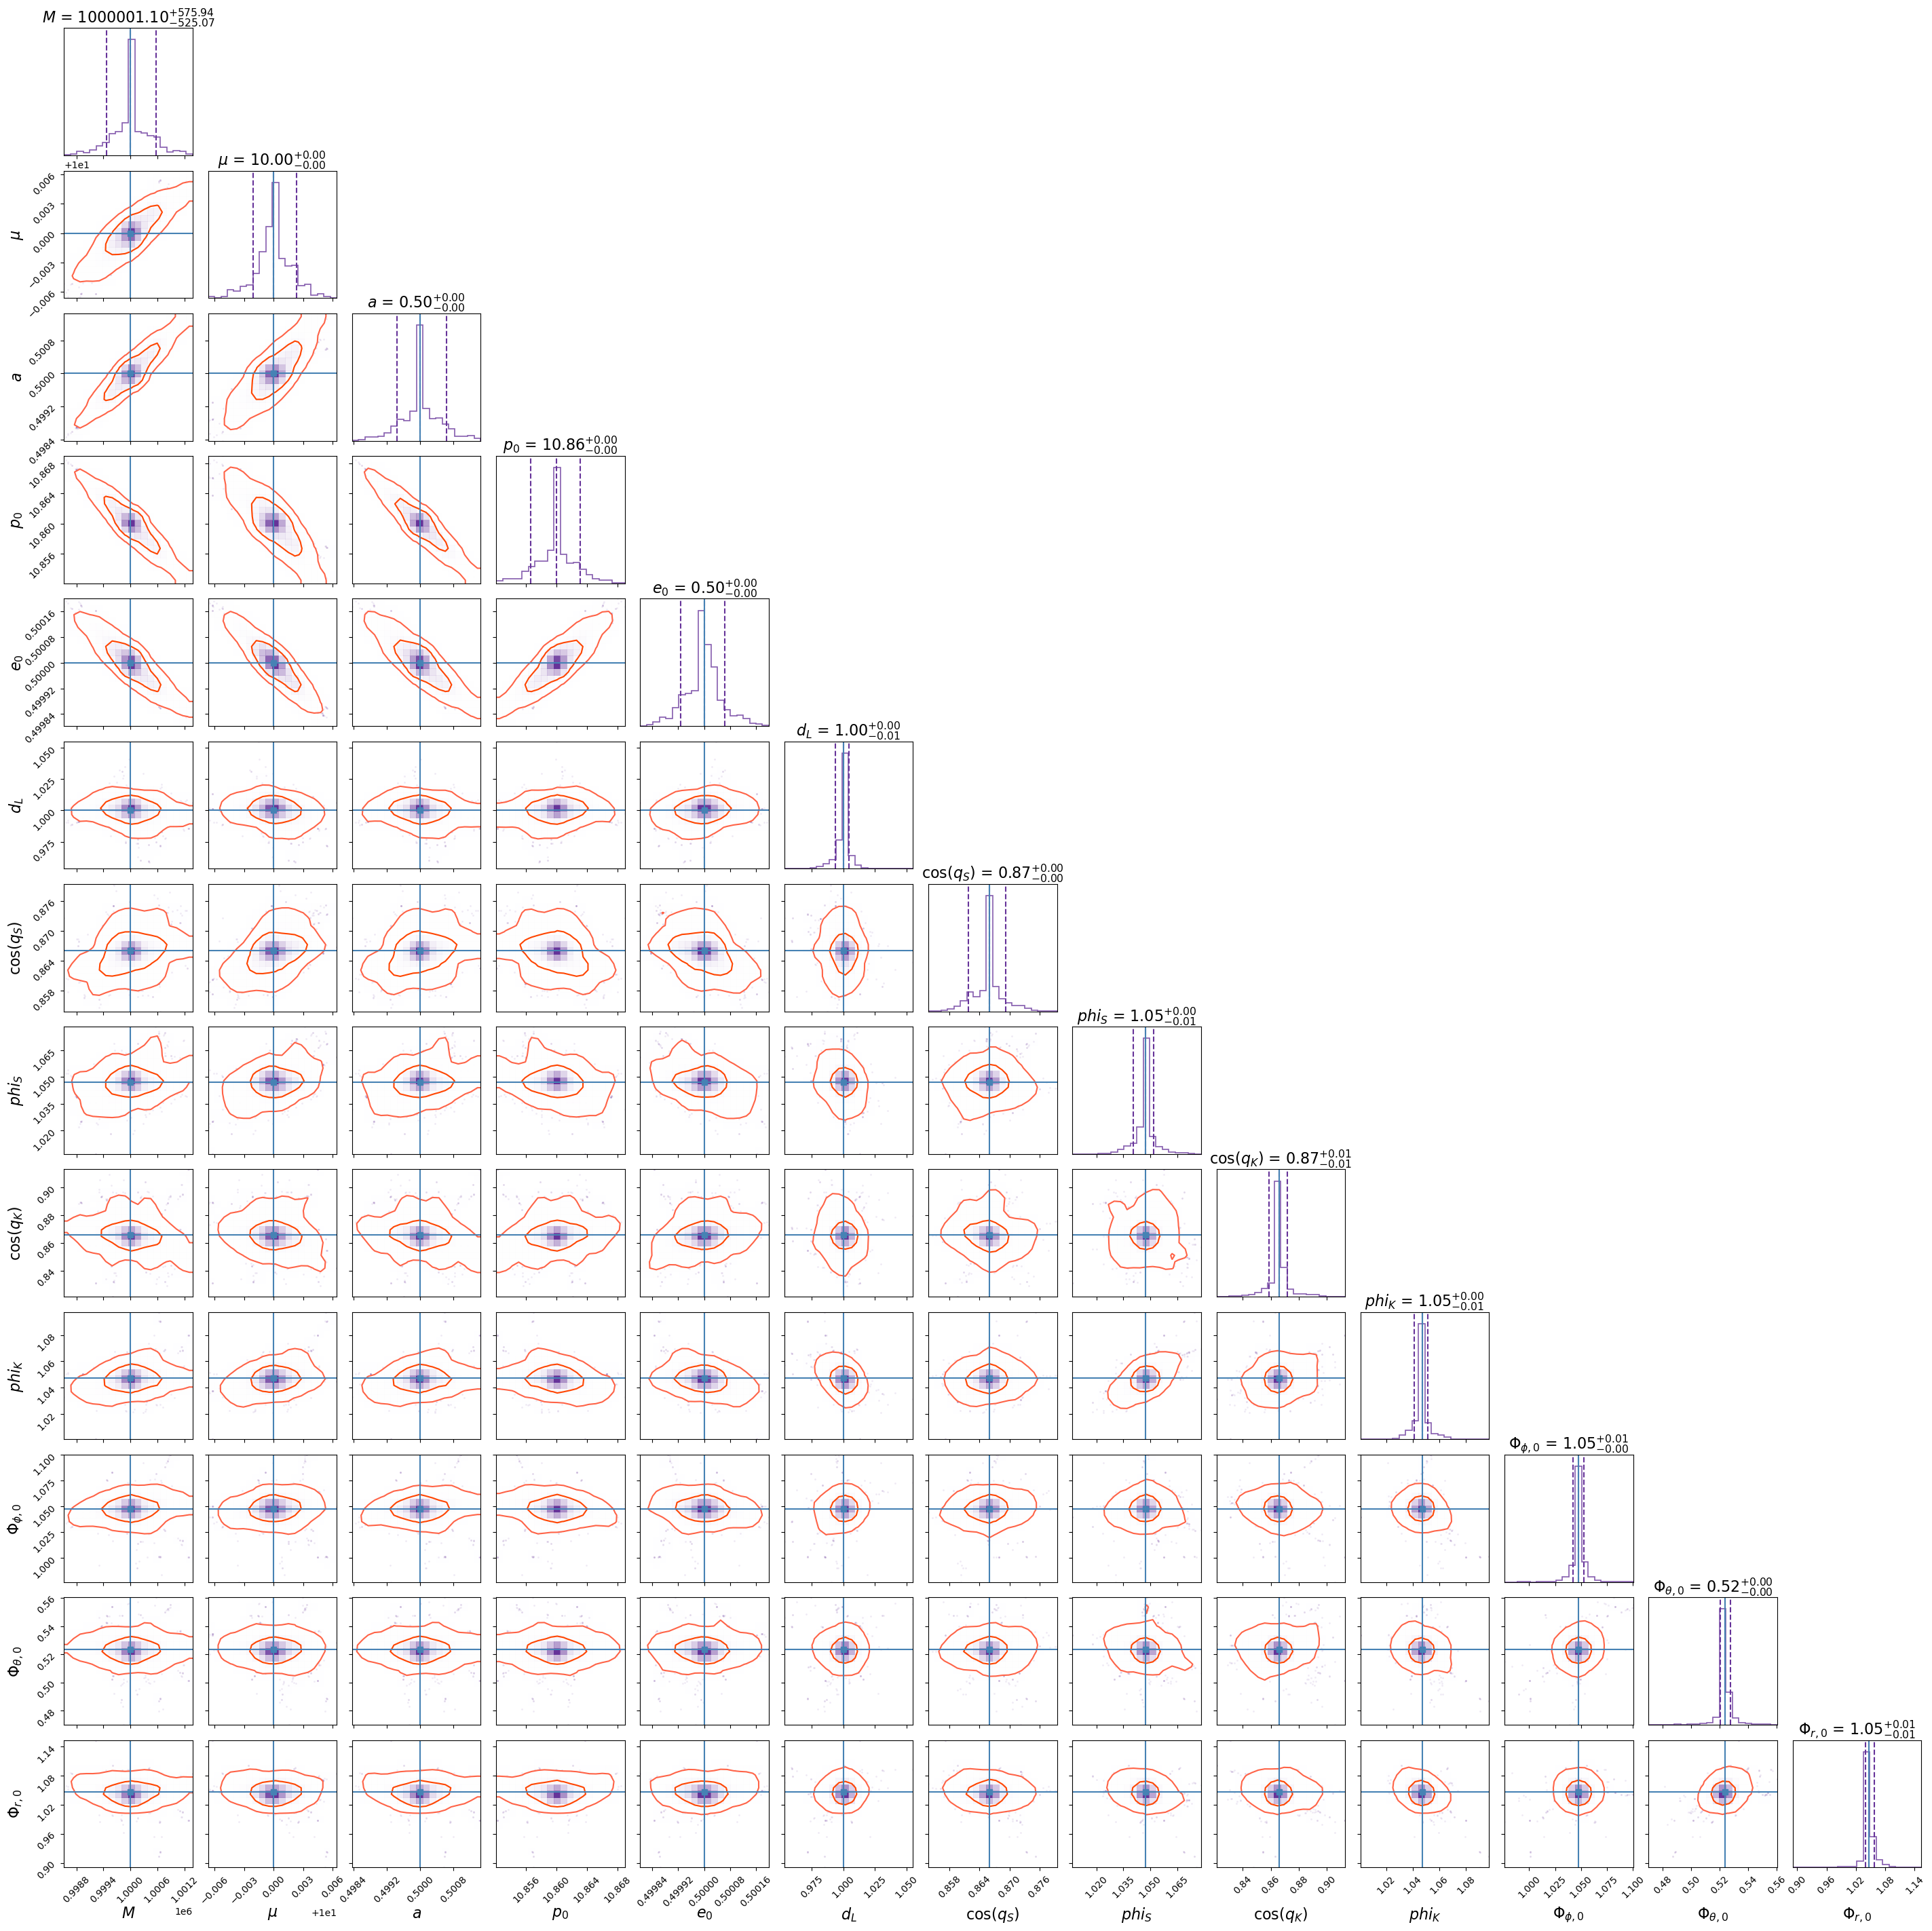

In [8]:
labels = [r'$M$', r'$\mu$', r'$a$', r'$p_0$', r'$e_0$', r'$d_L$', r'$\cos(q_S)$', r'$phi_S$', r'$\cos(q_K)$', r'$phi_K$', r'$\Phi_{\phi,0}$', r'$\Phi_{\theta,0}$', r'$\Phi_{r,0}$',]
true_param = [1e6, 10, 0.5, 9.38, 0.5, 1.0, np.cos(np.pi / 6), np.pi / 3, np.cos(np.pi / 6), np.pi / 3, np.pi / 3, np.pi / 6, np.pi / 3]

fig = corner.corner(chains["chain_1"], labels=labels, truths=true_param, levels=[0.68, 0.95],
                    quantiles=[0.10, 0.5, 0.90], show_titles=True, title_fmt=".2f",
                    plot_density=True, smooth=True, color='rebeccapurple',
                    hist_kwargs={'alpha': 0.8, 'edgecolor': 'rebeccapurple', 'linewidth': 1.2,},
                    contour_kwargs={'colors': ['tomato', 'orangered' ], 'linewidths': 1.5,},
                    title_kwargs={'fontsize': 16 },
                    label_kwargs={"fontsize": 16, "labelpad": 8}
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.12, hspace=0.12)
plt.show()

Median and percentiles

In [9]:
def fmt(x):
    return f"{x:.3g}"  # 3 cifre significative

# larghezza della colonna label
w_label = max(len(l) for l in labels) + 2

for label, col in zip(labels, flat_samples.T):
    low, med, up = np.percentile(col, [5, 50, 95])
    err_low, err_up = med - low, up - med

    print(
        f"{label:<{w_label}}"
        f"{fmt(med):>8}   "
        f"+{fmt(err_up):<6} "
        f"-{fmt(err_low):<6}"
    )

$M$                   1e+06   +11.4   -11.2  
$\mu$                    10   +4.67e-05 -4.76e-05
$a$                     0.5   +1.09e-05 -1.05e-05
$p_0$                  10.9   +6.21e-05 -6.27e-05
$e_0$                   0.5   +2.09e-06 -2.12e-06
$d_L$                     1   +0.00245 -0.00184
$\cos(q_S)$           0.866   +0.000718 -0.000925
$phi_S$                1.05   +0.00107 -0.00141
$\cos(q_K)$           0.866   +0.00316 -0.00227
$phi_K$                1.05   +0.00138 -0.00178
$\Phi_{\phi,0}$        1.05   +0.00526 -0.00247
$\Phi_{\theta,0}$     0.524   +0.00147 -0.00321
$\Phi_{r,0}$           1.05   +0.00295 -0.00292
